In [44]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.special import expit

import ssm
from ssm import transitions 

import scipy.io
import os
import pandas as pd
import seaborn as sns
import glmhmmFunctions as ghf

In [45]:
# load data
filename = '/Users/mpexirra/Documents/data/muscimoldata'
data = scipy.io.loadmat(filename)
data = data['muscimoldata']

In [46]:
# defining plot colors
stimcolors = sns.color_palette("rocket_r")
colors = ['gold', 'plum', 'lightskyblue', 'red']

In [47]:
# all data as a data frame
df = pd.DataFrame(data)
df.columns = ['animal', 'sessionid', 'trialnumber', 'trial_block', 'lotterymag', 'lotteryprob', 
           'surebetmag', 'rewardreceived', 'lotterychoice', 'lotteryoutcome', 'musdose', 'region']

In [48]:
# adding/modifying relevant variables to data frame
df.animal = df.animal.astype(int)

df['choiceout'] = np.zeros(len(df))
df.loc[(df.lotterychoice == 1) & (df.lotteryoutcome == 1),['choiceout']] = 1
df.loc[(df.lotterychoice == 1) & (df.lotteryoutcome == 0),['choiceout']] = -1

df.loc[df.region == 1, 'region'] = 'ctrl'
df.loc[df.region == 2, 'region'] = 'fof'
df.loc[df.region == 3, 'region'] = 'ppc'

In [49]:
# getting normalized EVs for each animal
df['deltaEV'] = np.zeros(len(df))
df['normdeltaEV'] = np.zeros(len(df))
animals = df['animal'].unique()
nanimals = len(animals)

for aa in range(nanimals):
    animaldata = df[df['animal'] == animals[aa]]
    sessions = animaldata['sessionid'].unique()
    nsessions = len(sessions)

    for ss in range(nsessions):
        sessiondata = animaldata[animaldata['sessionid'] == sessions[ss]]
        ntrials = len(sessiondata)

        sbmag = sessiondata.surebetmag[sessiondata.lotterychoice == 0].unique()
        sbrwd = sessiondata.rewardreceived[sessiondata.lotterychoice == 0].unique()
        rwdmult = sbrwd/sbmag
        lotteryprob = sessiondata.lotteryprob.unique()
    
        # getting and saving deltaEV information
        deltaEV = rwdmult * (sessiondata.lotterymag * lotteryprob) - sbrwd
        df.loc[(df['animal'] == animals[aa]) & (df['sessionid'] == sessions[ss]), ['deltaEV']] = deltaEV
    maxEV = df.deltaEV[df.animal == animals[aa]].max()
    df.loc[df['animal'] == animals[aa], 'normdeltaEV'] = df.deltaEV[df['animal'] == animals[aa]]/maxEV

In [50]:
# creating Y and input structures
inputdim = 2
inputs = []
Y = []
sessions = df['sessionid'].unique()
nsessions = len(sessions)

for ss in range(nsessions):
    sessiondata = df[df['sessionid'] == sessions[ss]]
    ntrials = len(sessiondata)
    inputs.append(np.ones([ntrials, inputdim]))
    Y.append(np.zeros([ntrials,1], dtype = int))
    inputs[ss][:,0] = sessiondata.deltaEV
    Y[ss][:,0] = sessiondata.lotterychoice

In [8]:
# checking best nstates fit
maxstates = 15
inputdim = 2
obsdim = 1
ncatergories = 2
niterations = 500

statell = np.zeros(maxstates)
for kk in range(maxstates):
    nstates = kk + 1
    glmhmm = ssm.HMM(nstates, obsdim, inputdim,  observations = 'input_driven_obs',
    observation_kwargs = dict(C = ncatergories), transitions = "standard")
    
    glmhmm2fit = glmhmm.fit(Y, inputs = inputs, method = 'em', num_iters = niterations, tolerance = 10**-4)

    statell[kk] = glmhmm2fit[-1]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

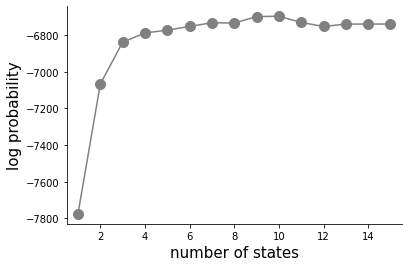

In [9]:
#plotting LL for each number of states
fig, ax = plt.subplots(1,1)
xx = np.arange(maxstates) + 1
plt.plot(xx, statell, marker = 'o', markersize = 10, color = 'gray', linestyle = '-')

# axis options
plt.xlabel('number of states', fontsize = 15)
plt.xlim(.5, maxstates + .5)
plt.ylabel('log probability', fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 


In [11]:
# setting glm-hmm parameters
nstates = 3
obsdim = 1
ncatergories = 2
niterations = 300

# creating new df variables for estimated states from glmhmm
df['pstate1'] = np.zeros(len(df))
df['pstate2'] = np.zeros(len(df))
df['pstate3'] = np.zeros(len(df))
df['state'] = np.zeros(len(df))

glmhmm = ssm.HMM(nstates, obsdim, inputdim,  observations = 'input_driven_obs',
            observation_kwargs = dict(C = ncatergories), transitions = "standard")
glmhmm2fit = glmhmm.fit(Y, inputs = inputs, method = 'em', num_iters = niterations, tolerance = 10**-5)

# saving the glm weights and transition matrix values
w = - glmhmm.observations.params.reshape(nstates,inputdim)
transmat = glmhmm.transitions.transition_matrix

# getting expected states
posterior_pstate = [glmhmm.expected_states(data = data, input = inputs)[0]
                    for data, inputs
                    in zip(Y, inputs)]


  0%|          | 0/300 [00:00<?, ?it/s]

In [54]:
# saving expected states  for each trialin the data frame
ppstate_aux = np.array([item for sublist in posterior_pstate for item in sublist])
df['pstate1'] = ppstate_aux[:,0]
df['pstate2'] = ppstate_aux[:,1]
df['pstate3'] = ppstate_aux[:,2]

df.state = df[['pstate1', 'pstate2', 'pstate3']].idxmax(axis = 1)    

/var/folders/cg/jhwhw7qn5gl9_pb586p8cmf80000gp/T/ipykernel_52041/1987631765.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.state = df[['pstate1', 'pstate2', 'pstate3']].idxmax(axis = 1)


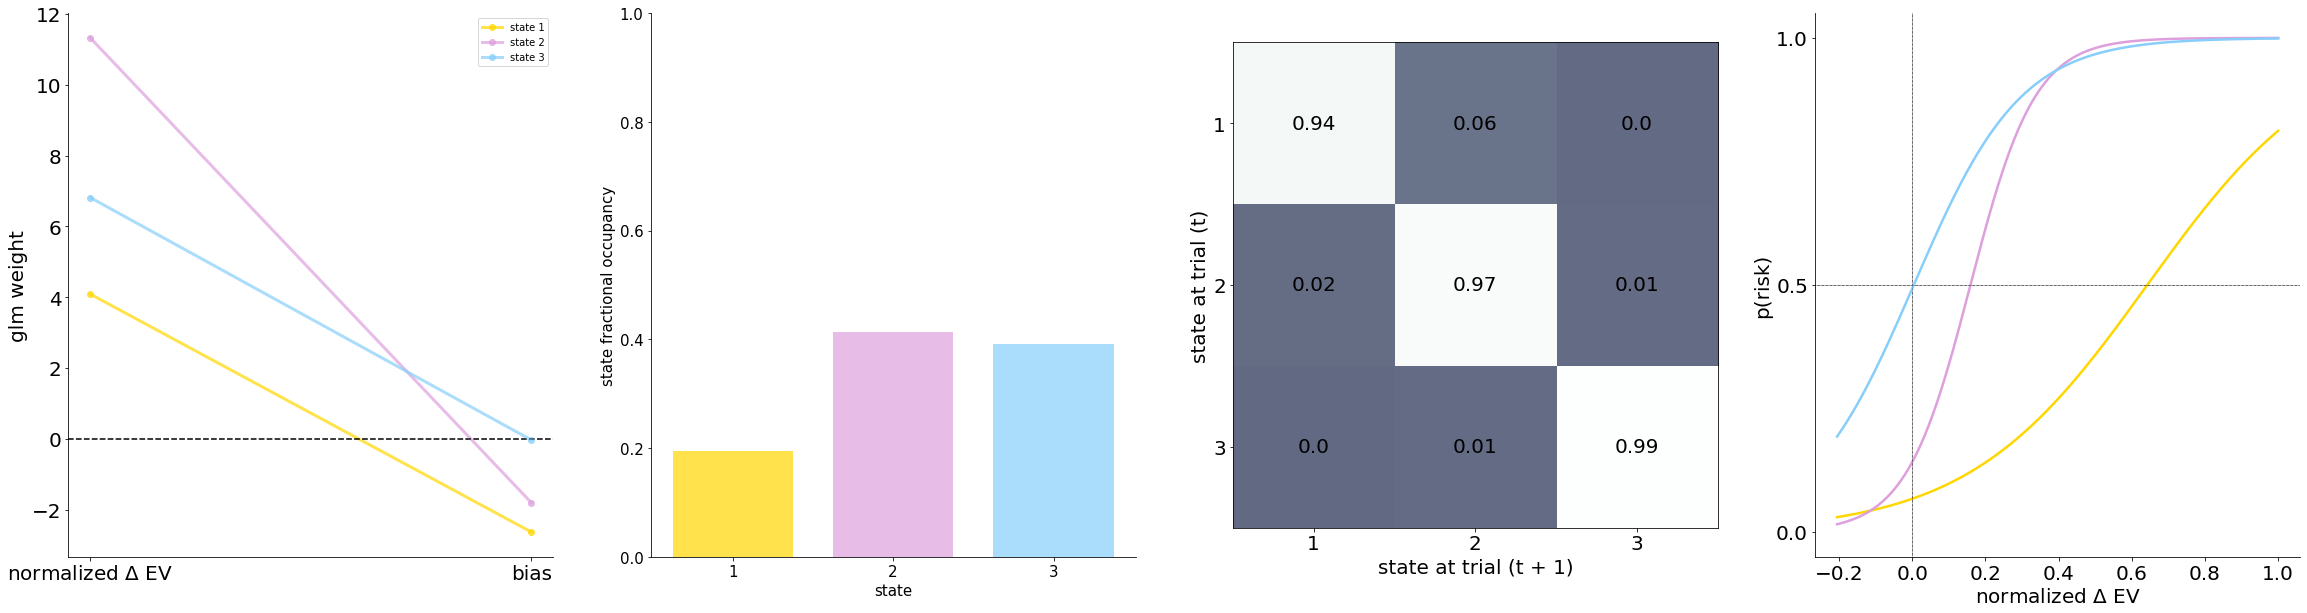

In [40]:
fig, ax = plt.subplots(1, 4, figsize = (40,10))

# getting relevant data
evs = np.unique(inputs[0][:,0])
evspace = np.linspace(np.min(evs), np.max(evs), 1000)
X = np.array([
evspace,
np.repeat(1, len(evspace))]).T

transitionmatrix = transmat

for kk in range(nstates):             
    glmweights = w[kk,:]
    wX = np.matmul(X, glmweights)

    ## plot glm weights for each covariate
    plt.subplot(1,4,1)
    plt.plot(range(inputdim), glmweights, marker = 'o', lw = 3,
             color = colors[kk], alpha = .7, linestyle = '-', label = 'state ' + str(kk+1))

    # axis options
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('glm weight', fontsize = 20)
    plt.xticks(range(inputdim), ['normalized $\Delta$ EV ', 'bias'],  fontsize = 20)
    plt.axhline(y = 0, color = 'k', alpha = .5, ls = '--')
    plt.legend()
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ## plot fractional occupancy
    plt.subplot(1,4,2)
    occ = sum(df.state == statestr[kk])/len(df)
    plt.bar(kk, occ, width = .75, color = colors[kk], alpha = .7)

    # axis options
    plt.ylim((0,1))
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('state', fontsize = 15)  
    plt.ylabel('state fractional occupancy', fontsize = 15)
    plt.xticks([0,1,2], ['1','2','3'], fontsize = 15)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    ## plot transition matrix
    plt.subplot(1,4,3)
    plt.imshow(transitionmatrix, vmin = -.8, vmax = 1, cmap = 'bone')

    for jj in range(nstates):
        text = plt.text(jj, kk, str(np.round(transitionmatrix[kk, jj],2)), ha = 'center', va = 'center', color = 'k', fontsize = 20)

        plt.xlim(-.5, nstates - .5)
        plt.xticks(range(0, nstates), ('1', '2', '3'), fontsize = 20)
        plt.yticks(range(0, nstates), ('1', '2', '3'), fontsize = 20)
        plt.ylim(nstates - .5, -.5)
        plt.ylabel('state at trial (t)', fontsize = 20)
        plt.xlabel('state at trial (t + 1)', fontsize = 20)


    ## plot glm psycurves
    plt.subplot(1,4,4)
    plt.plot(evspace, expit(wX), lw = 2.5, color = colors[kk])

    # reference lines
    plt.axvline(0, linestyle = ':', c = 'k',  lw = .5)
    plt.axhline(.5, linestyle = ':', c = 'k', lw = .5)

    # axis options
    plt.ylim((-.05, 1.05))
    plt.xlabel('normalized $\Delta$ EV',  fontsize = 20)  
    plt.ylabel('p(risk)', fontsize = 20)
    ax[3].set_yticks([0, .5, 1])
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)


pstate3    0.388994
pstate2    0.377728
pstate1    0.233278
Name: state, dtype: float64
pstate2    0.465762
pstate3    0.360465
pstate1    0.173773
Name: state, dtype: float64
pstate3    0.755839
pstate2    0.244161
Name: state, dtype: float64
pstate2    0.533052
pstate3    0.286920
pstate1    0.180028
Name: state, dtype: float64
pstate2    0.563430
pstate3    0.258682
pstate1    0.177888
Name: state, dtype: float64
pstate2    0.424533
pstate3    0.409067
pstate1    0.166400
Name: state, dtype: float64
pstate3    0.472763
pstate2    0.366732
pstate1    0.160506
Name: state, dtype: float64
pstate3    0.507634
pstate2    0.342239
pstate1    0.150127
Name: state, dtype: float64


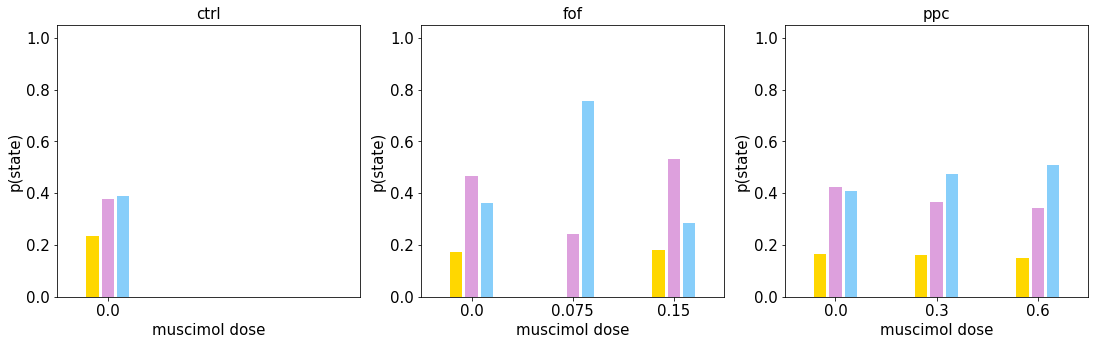

In [41]:
statestr = ['pstate1','pstate2','pstate3']
regions = df.region.unique()
nregions = len(regions)
evs = np.unique(df.deltaEV)
evspace = np.linspace(np.min(evs), np.max(evs), 1000)
X = np.array([
    evspace,
    np.repeat(1, len(evspace))]).T
transitionmatrix = np.round(transmat, 2)

fig, ax = plt.subplots(1, nregions, figsize = (25,5))

for rr in range(nregions):
    regiondata = df[df.region == regions[rr]]
    musdoses = np.sort(regiondata.musdose.unique())
    ndoses = len(musdoses)

    plt.subplot(1, nregions + 1, rr + 1)
    plt.title(regions[rr], fontsize = 15)
    
    for mm in range(ndoses):
        musdosedata = regiondata[regiondata.musdose == musdoses[mm]]
        occ = musdosedata['state'].value_counts()/len(musdosedata)
        print(occ)
        occ = occ.reindex(index = statestr)
        occ = np.nan_to_num(occ)
        
        xx = np.linspace(-.15 , .15, nstates)
        plt.bar(xx + mm, occ, color = colors, label = statestr, width = .12)
        
    # axis options
    plt.xlabel('muscimol dose',  fontsize = 15)  
    plt.ylabel('p(state)', fontsize = 15)
    plt.xticks(range(0, ndoses), musdoses)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlim((-.5, 2.5))
    plt.ylim((0, 1.05))
    ax[rr].spines['top'].set_visible(False)
    ax[rr].spines['right'].set_visible(False) 

In [43]:
df.groupby(['region','musdose']).agg('mean')

animal      sessionid  trialnumber  trial_block  \
region musdose                                                         
ctrl   0.000    2155.713828  172174.300522    65.694379    22.190821   
fof    0.000    2157.056202  186677.765504    70.005491    22.373062   
       0.075    2153.645435  178797.577495    62.543524    21.532909   
       0.150    2159.573840  198283.540084    63.593530    19.448664   
       0.300    2158.043940  190649.097803    60.170092    21.746988   
ppc    0.000    2156.520533  180099.564267    62.728000    22.399467   
       0.300    2155.274319  173739.937743    68.356031    22.132296   
       0.600    2157.961832  188318.786260    55.979644    23.660305   

                lotterymag  lotteryprob  surebetmag  rewardreceived  \
region musdose                                                        
ctrl   0.000     10.320683     0.513781    3.000000       62.685484   
fof    0.000     10.441214     0.511644    3.005993       66.698735   
       0.075     10.271762     0.512633    3.000000       63.244161   
       0.150     10.222222     0.521097    3.761010       86.028270   
       0.300     10.412473     0.512013    3.376801       63.989265   
ppc    0.000     10.376533     0.512347    3.057227       65.153067   
       0.300     10.276265     0.512208    3.000000       63.058366   
       0.600     10.343511     0.511196    3.304326       69.682952   

                lotterychoice  lotteryoutcome  choiceout   deltaEV   pstate1  \
region musdose                                                                 
ctrl   0.000         0.412358        0.510555   0.005100  0.154608  0.242900   
fof    0.000         0.424096        0.501938   0.000969  0.155592  0.190555   
       0.075         0.437367        0.513800   0.021231  0.154719  0.016441   
       0.150         0.399437        0.544304   0.061885  0.109921  0.193653   
       0.300         0.330971        0.501772  -0.006378  0.128335  0.200483   
ppc    0.000         0.458667        0.491200  -0.003200  0.149732  0.180914   
       0.300         0.398833        0.531128   0.015564  0.154386  0.149928   
       0.600         0.451654        0.507634  -0.011450  0.126920  0.146287   

                 pstate2   pstate3  
region musdose                      
ctrl   0.000    0.366929  0.390172  
fof    0.000    0.443187  0.366258  
       0.075    0.236716  0.746844  
       0.150    0.509117  0.297230  
       0.300    0.539196  0.260320  
ppc    0.000    0.417804  0.401282  
       0.300    0.382515  0.467558  
       0.600    0.369710  0.484003

In [55]:
# psycurves with data - plot for each region & dose
# change normalization
#

In [53]:
df

,animal,sessionid,trialnumber,trial_block,lotterymag,lotteryprob,surebetmag,rewardreceived,lotterychoice,lotteryoutcome,musdose,region,choiceout,deltaEV,normdeltaEV
0,2152,158487.0,2.0,2.0,0.0,0.55,3.0,24.0,0.0,0.0,0.0,ctrl,0.0,-24.0,-0.205479
1,2152,158487.0,4.0,4.0,8.0,0.55,3.0,24.0,0.0,1.0,0.0,ctrl,0.0,11.2,0.095890
2,2152,158487.0,6.0,6.0,0.0,0.55,3.0,24.0,0.0,1.0,0.0,ctrl,0.0,-24.0,-0.205479
3,2152,158487.0,7.0,7.0,4.0,0.55,3.0,24.0,0.0,1.0,0.0,ctrl,0.0,-6.4,-0.054795
4,2152,158487.0,9.0,9.0,4.0,0.55,3.0,24.0,0.0,0.0,0.0,ctrl,0.0,-6.4,-0.054795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17805,2166,189035.0,88.0,24.0,16.0,0.60,3.0,256.0,1.0,1.0,0.6,ppc,1.0,105.6,0.350762
17806,2166,189035.0,89.0,25.0,0.0,0.60,3.0,48.0,0.0,1.0,0.6,ppc,0.0,-48.0,-0.159437
17807,2166,189035.0,90.0,26.0,4.0,0.60,3.0,48.0,0.0,1.0,0.6,ppc,0.0,-9.6,-0.031887
17808,2166,189035.0,92.0,28.0,4.0,0.60,3.0,48.0,0.0,1.0,0.6,ppc,0.0,-9.6,-0.031887
